# A Statistical Look at Basketball 2017- 2018 Season

## 1. Introduction
### Problem
Datasets containing information about the NBA, both statistics for players and overall teams, are plentiful. Playoffs for the the 2017-2018 season are currently underway and it would be interesting to see if a predictor can be made which takes information from the regular season, and applies that data to the post season to make some playoffs predictions. 

### Approach
A

### Deliverables
The playoffs games will continue and end well after the project is due, so we will not be able to check the playoff predictions as a means of gauging success. While the model will be used to make predictions for the playoff games, it will not be a measure of success. Instead, what I want to do is create a predictor that is able to achieve at least 90% accuracy when trained and tested on the regular season games. Furthermore, wherever possible, the models will be inspected to see how different statistics are used to come to a decsion. 

In [46]:
import urllib2
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Directories
dir_data = "Data"
dir_figures = "Figures"
# File Paths
file_game_stats = dir_data +  "/1718_season_stats.csv"
file_player_stats = dir_data + "/PaulRossotti_Kaggle/2017-18_playerBoxScore.csv"
file_team_stats = dir_data + "/PaulRossotti_Kaggle/2017-18_teamBoxScore.csv"
file_team_map = dir_data + "/teamMapping.csv"


## 2. Webscraping
We're gonna need some information about the season schedule. We're interested in what teams played eachother and what the outcomes of the games were. [This website](https://www.basketball-reference.com/leagues/NBA_2018_games.html) contains the shedule, teams and scores for us to create a data set with. We just need to scrape the data into a CSV file.

In [47]:
url_head = "https://www.basketball-reference.com/leagues/NBA_2018_games-"
url_tail = ".html"
monthsOfSeason = ["october", "november", "december", "january", "february", "march", "april"]

URLs = []
for month in monthsOfSeason:
        URLs.append( url_head + month + url_tail)

In [48]:
FP_season_stats = open(file_game_stats, "w")

# set headers
FP_season_stats.write("gmDate,T1name,T1score,T2name,T2score,outcome\n")

for url in URLs:
    source = urllib2.urlopen(url).read();
    soup = BeautifulSoup(source, "lxml")
    rows = soup.find("tbody").findAll("tr")
    
    
    for row in rows:
        col_date = row.find("th")
        col = row.findAll("td")
        
        # Exit Condition, the web pages are organized by month and
        # playoff information is held in the same table separated
        # by a special header row which spans all the columns. If we 
        # only find a single column, we've hit the end of the regular
        # season data.
        if len(col) < 4:
            break;
        
        # Defining our information variables
        dateObj = datetime.strptime(col_date.text, "%a, %b %d, %Y")
        game_date = dateObj.date()
        team_1_name = col[1].text
        team_1_score = int(col[2].text)
        team_2_name = col[3].text
        team_2_score = int(col[4].text)
        outcome = (0 if (team_1_score > team_2_score) else  1)
        
        
        # Writing those variables to the CSV file
        FP_season_stats.write(str(game_date) + "," 
                              + team_1_name + "," 
                              + str(team_1_score) + "," 
                              + team_2_name + "," 
                              + str(team_2_score) + ","
                              + str(outcome) + "\n")

# Confirm our changes
FP_season_stats.close()

## 3. Data Cleaning

In [49]:
df_game_stats = pd.read_csv(file_game_stats)
df_player_stats = pd.read_csv(file_player_stats)
df_mapping = pd.read_csv(file_team_map)

# Create maps for cleaning
code2number = df_mapping.code.to_dict()
name2number = df_mapping.name.to_dict()

def invertDictionary(dictionary):
    return {v:k for k,v in dictionary.items()}

code2number = invertDictionary(code2number)
name2number = invertDictionary(name2number)
pos2number = {}
loc2number = {"Away":0, "Home":1}
result2number = {"Loss":0, "Win":1}

positions = df_player_stats["playPos"].unique()
for i in range(len(positions)):
    pos2number[positions[i]] = i


# Clean Game Statistics
df_game_stats["T1name"] = df_game_stats["T1name"].replace(name2number)
df_game_stats["T2name"] = df_game_stats["T2name"].replace(name2number)


# Clean Player Data
df_player_stats = df_player_stats.drop(["gmTime", "seasTyp",
                                        "playLNm", "playFNm",
                                        "teamConf", "teamDiv",
                                        "teamRslt",
                                        "offLNm1", #"teamDayOff",
                                        "offFNm1", "offLNm2",
                                        "offFNm2", "offLNm3",
                                        "offFNm3", "playStat",
                                        "playBDate", "playTRB",
                                        "opptAbbr", "opptConf", 
                                        "opptDiv", "opptLoc",
                                        "opptRslt", "opptDayOff"]
                                       , axis=1)


df_player_stats["teamAbbr"] = df_player_stats["teamAbbr"].replace(code2number)
df_player_stats["teamLoc"] = df_player_stats["teamLoc"].replace(loc2number)
df_player_stats["playPos"] = df_player_stats["playPos"].replace(pos2number)

## 4. Getting Season Averages

In [50]:
unique_players = df_player_stats.playDispNm.unique()

df_player_season_avg = df_player_stats.drop(["gmDate", "teamAbbr", "teamLoc", "teamDayOff"],axis=1)
df_player_season_avg = df_player_season_avg.groupby("playDispNm").mean()
df_player_season_avg["playPos"] = df_player_season_avg["playPos"].astype(np.int32)

## 5. Basic EDA

In [51]:
df_player_season_avg.to_csv(dir_data+"/player_season_totals.csv")
df_team_season_avg = pd.read_csv(file_team_stats).groupby("teamAbbr").mean()

C green
G black
F red
PF orange
PG blue
SG purple
SF magenta


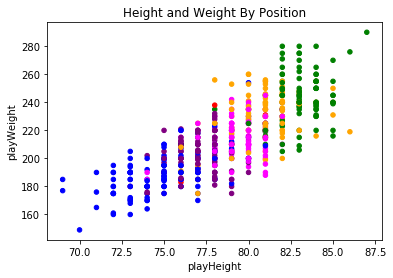

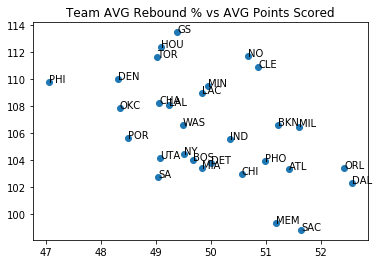

In [94]:
colors = {0:"red", 1:"blue",2:"magenta", 3:"green", 4:"orange", 5:"purple", 6:"black"}
for k in pos2number:
    print k + " " + colors[pos2number[k]]

plt.figure()
df_player_season_avg.plot(kind='scatter', x='playHeight', y='playWeight', c=df_player_season_avg["playPos"].apply(lambda x: colors[x]))
plt.title("Height and Weight By Position")
plt.savefig(dir_figures+"/HWbyPos.png")
plt.show()

plt.figure()
fig, ax = plt.subplots()
x = "opptTREB%"
y = "teamPTS"
ax.scatter(df_team_season_avg[x], df_team_season_avg[y])

for i, txt in enumerate(df_team_season_avg.index):
    ax.annotate(txt, (df_team_season_avg[x][i], df_team_season_avg[y][i]))
plt.title("Team AVG Rebound % vs AVG Points Scored")
plt.savefig(dir_figures+"/teamStuff.png")
plt.show()

In [115]:
## Looking at correlations with points scored

weight_test_data = df_player_stats.drop(["gmDate", "teamAbbr"], axis=1)
weights_home = {}
weights_away = {}
threshold = 0.5
home_stats = weight_test_data[weight_test_data["teamLoc"] == 0]
away_stats = weight_test_data[weight_test_data["teamLoc"] == 1]
for i in range(3, len(weight_test_data.keys())):
    key = weight_test_data.keys()[i]
    plt.figure()
    home_correlation = np.corrcoef(home_stats[key], home_stats["playPTS"])
    away_correlation = np.corrcoef(away_stats[key], away_stats["playPTS"])
    difference = round(home_correlation[0][1] - away_correlation[0][1], 5)
    weights_home[key] = (round(home_correlation[0][1],5))
    weights_away[key] = (round(away_correlation[0][1],5))
    
    #if abs(home_correlation[0][1]) > threshold or abs(away_correlation[0][1]) > threshold:
    print key
    print "\tH- " + str(round(home_correlation[0][1], 3))
    print "\tA- " + str(round(away_correlation[0][1], 3))
        
    if difference > 0.01:
        print str(difference) + "\t" + key
        
print weights_home
print weights_away

playMin
	H- 0.723
	A- 0.726
playPos
	H- -0.04
	A- -0.03
playHeight
	H- -0.037
	A- -0.034
playWeight
	H- -0.021
	A- -0.017
playPTS
	H- 1.0
	A- 1.0
playAST
	H- 0.42
	A- 0.427
playTO
	H- 0.411
	A- 0.414
playSTL
	H- 0.282
	A- 0.297
playBLK
	H- 0.175
	A- 0.199
playPF
	H- 0.261
	A- 0.272
playFGA
	H- 0.873
	A- 0.878
playFGM
	H- 0.962
	A- 0.962
playFG%
	H- 0.442
	A- 0.439
play2PA
	H- 0.757
	A- 0.771
play2PM
	H- 0.805
	A- 0.808
play2P%
	H- 0.384
	A- 0.382
play3PA
	H- 0.582
	A- 0.564
0.01803	play3PA
play3PM
	H- 0.627
	A- 0.614
0.01216	play3PM
play3P%
	H- 0.396
	A- 0.402
playFTA
	H- 0.627
	A- 0.637
playFTM
	H- 0.636
	A- 0.65
playFT%
	H- 0.488
	A- 0.501
playORB
	H- 0.225
	A- 0.23
playDRB
	H- 0.437
	A- 0.432
{'playPos': -0.04022, 'play3PM': 0.62665, 'playWeight': -0.02093, 'play2PA': 0.75683, 'play2PM': 0.80496, 'playFT%': 0.48827, 'play3PA': 0.58158, 'playPTS': 1.0, 'playAST': 0.41989, 'playMin': 0.7226, 'playBLK': 0.17538, 'playPF': 0.26108, 'playORB': 0.22523, 'playSTL': 0.28236, 'playFTM': 0.63

## 6. Supervised Learning
## Trainable Dataset Attempt 1

### Idea:    
Dataset of games:    
{[G1],[G2],...[G_k]}

Game layout:   
[G1] = {Team_1_stat_1, Team_1_stat_2, ... , Team_2_stat_n, outcome }

In the above layout, outcome will be 0 when team 1 was the winner, 1 when team 2 is the winner.

Team stats will be made of averages taken from each player in their specific 

In [54]:
### We need to split the data into train and test sets.
### The datasets will always be organized by Date and Time.
### Let's create a sample based on indicies. There are 
### easier ways to do this but this seems intuitive.

# Create List of indicies for each game
indicies = range(len(df_game_stats))

# Split Indicies into train and test sets
i_train, i_test, i_train, i_test = train_test_split(indicies, indicies, test_size=0.33)

# Usage:
# z = [games[i] for i in x_train[:10]]

In [55]:
df_player_stats_numeric = df_player_stats.drop(["playDispNm"], axis=1);

games = []
labels = []
for index, match in df_game_stats.iterrows():
    date = match.gmDate
    home = match.T1name
    away = match.T2name
    
    game = []
    team1 = []
    team2 = []
    
    filter_by_date = df_player_stats_numeric[df_player_stats["gmDate"]==date]
    
    #Team 1
    filter_by_team = filter_by_date[filter_by_date["teamAbbr"]==home]
    filter_by_team = filter_by_team.drop(["gmDate"], axis=1)
    game.extend(filter_by_team.mean().tolist())
    #for index, player in filter_by_team.iterrows():
    #    team1.append(player.tolist())
        
    #Team 2
    filter_by_team = filter_by_date[filter_by_date["teamAbbr"]==away]
    filter_by_team = filter_by_team.drop(["gmDate"], axis=1)
    game.extend(filter_by_team.mean().tolist())
    #for index, player in filter_by_team.iterrows():
    #    team2.append(player.tolist())
        
    #game.append(team1)
    #game.append(team2)
    games.append(game)
    labels.append(match.outcome)

In [56]:
### Trial 1 - Default Decision Tree
x_train = [games[i] for i in i_train]
y_train = [labels[i] for i in i_train]
x_test = [games[i] for i in i_test]
y_test = [labels[i] for i in i_test]

clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

predictions = clf.predict(x_test)
print accuracy_score(y_test, predictions)

0.660098522167


In [57]:
### Exporting Tree to understand what statistics are being looked at
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("Stuff")

'Stuff.pdf'

In [58]:
# Trial 2 - Optimized Decsion Tree
clf = tree.DecisionTreeClassifier(criterion="gini",max_depth=12,max_leaf_nodes=20)
clf = clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print str(accuracy_score(y_test, predictions))

0.692118226601


In [59]:
#Default Random Forest
clf = RandomForestClassifier()
clf = clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print accuracy_score(y_test, predictions)

0.709359605911


In [60]:
# Default Logistic Regression
model = LogisticRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)

print accuracy_score(y_test, predictions)

0.987684729064


## Trainable Dataset Attempt 2

The first dataset averages how each player perfroms on the day for the team and then uses that to predict the outcome on the day. I want to see what would happen to the accuracy if we use season averages for every game to train the model. 

Let's start with season averages. We'll have two separate averages. One for when a team is playing at home and one for when a team is playing away. And then we'll test how this effects the accuracy.

In [111]:
home_games = df_player_stats[df_player_stats["teamLoc"] == 0]
away_games = df_player_stats[df_player_stats["teamLoc"] == 1]

home_set = {}
away_set = {}
for val in code2number.values():
    team_home_set = home_games[home_games["teamAbbr"] == val]
    averages = team_home_set.drop(["gmDate","teamLoc"],axis=1).mean().tolist()
    home_set[val] = averages
    
    team_away_set = away_games[away_games["teamAbbr"] == val]
    averages = team_away_set.drop(["gmDate","teamLoc"],axis=1).mean().tolist()
    away_set[val] = averages

Now that we've split each team's statistics into their home averages and away averages, lets make the new 2D dataset.

In [114]:
### Creating Dataset 2 from separated team averages based on home games and away games
games2 = []
labels2 = []
for index, match in df_game_stats.iterrows():
    game = []
    home_team = match.T1name
    away_team = match.T2name
    game.extend(home_set[home_team])
    game.extend(home_set[away_team])
    
    labels2.append(match.outcome)
    games2.append(game)

Index([u'gmDate', u'teamLoc', u'teamDayOff', u'playDispNm', u'playMin',
       u'playPos', u'playHeight', u'playWeight', u'playPTS', u'playAST',
       u'playTO', u'playSTL', u'playBLK', u'playPF', u'playFGA', u'playFGM',
       u'playFG%', u'play2PA', u'play2PM', u'play2P%', u'play3PA', u'play3PM',
       u'play3P%', u'playFTA', u'playFTM', u'playFT%', u'playORB', u'playDRB'],
      dtype='object')
28


In [63]:
### Splitting Data to obtain testing and training sets
x_train = [games2[i] for i in i_train]
y_train = [labels2[i] for i in i_train]
x_test = [games2[i] for i in i_test]
y_test = [labels2[i] for i in i_test]

In [85]:
### Dataset 2 - Default Decision Tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print accuracy_score(y_test, predictions)

0.559113300493


In [88]:
# Dataset 2 - Optimized Decsion Tree
clf = tree.DecisionTreeClassifier(criterion="gini",max_depth=12,max_leaf_nodes=20)
clf = clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print str(accuracy_score(y_test, predictions))

0.600985221675


In [66]:
# Dataset 2 - Default Random Forest
clf = RandomForestClassifier()
clf = clf.fit(x_train, y_train)
predictions = clf.predict(x_test)
print accuracy_score(y_test, predictions)

0.637931034483


In [67]:
# Dataset 2 - Default Logistic Regression
model = LogisticRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)

print accuracy_score(y_test, predictions)

0.655172413793


In [122]:
print weights_home
print len(weights_home)
print weights_away
print len(weights_away)
print str(24+24)
print games2[1]
print len(games2[1])
print 52/2

print home_games.drop(["teamAbbr"],axis=1).columns
print len(home_games.drop(["teamAbbr"],axis=1).columns)

for key in home_games.drop(["gmDate","teamLoc","teamDayOff","playDispNm"],axis=1).columns:
    try:
        print str(key) + "\t" + str( weights_away[key])
    except:
        print str(key) + "\t" + "100"
        


{'playPos': -0.04022, 'play3PM': 0.62665, 'playWeight': -0.02093, 'play2PA': 0.75683, 'play2PM': 0.80496, 'playFT%': 0.48827, 'play3PA': 0.58158, 'playPTS': 1.0, 'playAST': 0.41989, 'playMin': 0.7226, 'playBLK': 0.17538, 'playPF': 0.26108, 'playORB': 0.22523, 'playSTL': 0.28236, 'playFTM': 0.63584, 'playTO': 0.41066, 'playHeight': -0.0366, 'play3P%': 0.39611, 'play2P%': 0.38446, 'playFG%': 0.44199, 'playDRB': 0.43718, 'playFGA': 0.87332, 'playFGM': 0.96246, 'playFTA': 0.62744}
24
{'playPos': -0.0296, 'play3PM': 0.6145, 'playWeight': -0.01748, 'play2PA': 0.77073, 'play2PM': 0.80756, 'playFT%': 0.50076, 'play3PA': 0.56355, 'playPTS': 1.0, 'playAST': 0.42682, 'playMin': 0.72622, 'playBLK': 0.19859, 'playPF': 0.27162, 'playORB': 0.22986, 'playSTL': 0.29661, 'playFTM': 0.64968, 'playTO': 0.41418, 'playHeight': -0.03421, 'play3P%': 0.40173, 'play2P%': 0.38199, 'playFG%': 0.43935, 'playDRB': 0.43229, 'playFGA': 0.87764, 'playFGM': 0.96187, 'playFTA': 0.63714}
24
48
[10.0, 1.7261306532663316, 

## Trainable dataset Attempt 3
Now we'll look at using the players data without averaging to make our training set.

In [68]:
for index, match in df_game_stats.iterrows():
    date = match.gmDate
    home = match.T1name
    away = match.T2name
    
    #game = []
    #team1 = []
    #team2 = []
    
    filter_by_date = df_player_stats_numeric[df_player_stats["gmDate"]==date]
    
    filter_by_team = filter_by_date[filter_by_date["teamAbbr"]==home]

## Game 2 Predictor

In [70]:
home = "BOS"
away = "PHI"

home = code2number[home]
away = code2number[away]

match = []
games2 = []

# Home Team Season Stats
filter_by_team = df_player_stats[df_player_stats["teamAbbr"]==home]
filter_by_team = filter_by_team.drop(["gmDate"], axis=1)
match.extend(filter_by_team.mean().tolist())

# Away Team Season Stats
filter_by_team = df_player_stats[df_player_stats["teamAbbr"]==away]
filter_by_team = filter_by_team.drop(["gmDate"], axis=1)
match.extend(filter_by_team.mean().tolist())

games2.append(match)

# Predict Game
prediction = model.predict(games2)

if prediction == 1:
    print "Home"
else:
    print "Away"



ValueError: X has 54 features per sample; expecting 52

It's expected that the accuracy would go down, because this doesn't factor any improvment for a team that happens over the course of the season. This would mean that we would expect predictions made for the end of the season to be more accurate than that of games in the beginning of the season. 

I also want to try appending the player data directly to the training set in the following format:
[G_k] = [Team_1_player_1_stat_1, Team_1_player_1_stat_2, ... , Team_2_player_m_stat_n ]

Taking just the first m players of each team, where m is the same as the lowest number of players played at any night, might yield some interesting information. 

From using the first training dataset, I've learned two things.
1. More work needs to be done in terms of representing the data in two dimensions.
1. 

There are some problems immediately visible with how I've setup the first dataset:
1. There's no way to distinguish the statistics for when a team was home and when a team was away. It's fairly well known that in Basketball, having home court advantage is usually a pretty big advantage.
1. Team statistics are created using player averages. This will unfairly effect teams who use more players in a game than a team which does not.
1. The data is not normalized to anything.
